# Danish Politics: Tweeting vs. meeting

Authors: Christian Engelbrekt Petersen, Frederik Kromann Hansen & Lau Johansson

# Motivation

In [69]:
import pickle
import tweepy
import re #https://developers.google.com/edu/python/regular-expressions
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import nltk
from nltk.collocations import *
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
#nltk.download('pos_tag')


import math

from PIL import Image


import community

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Describe datasets (goal -> what is dataset -> how does it answer goal)

### Twitter

On [twitterpolitikere.dk](https://filip.journet.sdu.dk/twitter/politikere/), twitterprofiles of 650 danish politicians has been collected. This will be the basis of the network. Each of the profiles should represent a node. 



The project uses tweets from Twitter in order to make a network which connects danish politicians. 

In order to get tweets, a developer account for twitter has been created. Tweet can then be assesed through Twitters API on https://developer.twitter.com/en.



### Politicians (parties and regions)

### Political meetings

# Basic stats

## Data cleaning

### Twitterprofiles

Initially all of the twitterprofiles are collected using the webpage https://filip.journet.sdu.dk/twitter/politikere/.

In [ ]:
from tqdm.notebook import tqdm
URL = 'https://filip.journet.sdu.dk/twitter/politikere/'
page = requests.get(URL)

In [ ]:
soup = BeautifulSoup(page.content, 'html.parser')


After inspecting the webpage, is it concluded that all twitternames are displayed in < h3 > classes. 

In [ ]:
twitter_names = soup.find_all('h3')

Creating a list to save all the twitter names.

In [ ]:
twitter_name_list=[]

Scraping all of the names from the webpage:

In [ ]:
for names in twitter_names:
    match=re.search("<h3>#",str(names))
    if match:
        result_name=re.findall(".com/\w*",str(names))[0].replace(".com/","")
        twitter_name_list.append(result_name.rstrip())
        #print(result_name)

For each of the twitternames (twitterprofiles) a corresponding real name is shown. The real politician names are displayed in < small > classes. Initially a empty list for all the names are created.

In [ ]:
real_name_list=[]

Thereafter, the webpage are scraped in order to find the realnames:

In [ ]:
real_names = soup.find_all('small')
for r_names in real_names:
    result=re.search(r'<small>.+',str(r_names)).group(0).replace("<small>","")
    real_name_list.append(result.rstrip())
    print(result)

All of the twittername with their corresponding real names are saved into a pandas dataframe.

In [ ]:
d={'Names':real_name_list,"Twittername":twitter_name_list}
data=pd.DataFrame(data=d)

In [ ]:
data.to_csv("danish_politkere_twitter.csv")

In [ ]:
data.head()

### Tweets

From twitter the only profiles needed is the politicians which just have been scraped.

The twitternames are saved in a list.

In [ ]:
twitter_name_list=list(data["Twittername"])

For using the API, both API key, API secret key, access token and access token-secret is needed. For privacy matter, these has been saved in files saved locally. The code below shows how the data are imported from our computers.

In [ ]:
#Load keys (everytime except first)
with open('api_key_'+User+'.data', 'rb') as filehandle:
    api_key = pickle.load(filehandle) 
with open('api_key_secret_'+User+'.data', 'rb') as filehandle:
    api_secret_key = pickle.load(filehandle)
with open('access_token_'+User+'.data', 'rb') as filehandle:
    access_token = pickle.load(filehandle)
with open('access_token_secret_'+User+'.data', 'rb') as filehandle:
    access_token_secret = pickle.load(filehandle)

For accessing twitter data, the library Tweepy has been used. Since only tweets from the politicians are needed, tweepy is very suitable for doing the job. Here is a link to the library webpage: https://www.tweepy.org/

Creating the API object which uses [OAuth](https://oauth.net/) for secure authorization. It enables interaction with the twitter API. 

In [ ]:
# Creating the authentication object
auth = tweepy.OAuthHandler(api_key, api_secret_key)
# Setting access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth)

To give a small introduction on how it works, below 5 tweets from the politician Margrethe Vestager is printed.

In [ ]:
# The Twitter user who we want to get tweets from
name = "vestager"
# Number of tweets to pull
tweetCount = 5

# Calling the user_timeline function with our parameters
tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

# foreach through all tweets pulled
for tweet in tweets:
    # printing the text stored inside the tweet object
    print(tweet.full_text)
    print(80 * '-')

The structure of dictionary is as follows:


* Vestager :
       Larslokke : [tweettextA, tweettextB] 
       oestergaard : [tweettextC] 


Each key correspond to a politician twitter profiles e.g. Vestager. Vestager has tagged Larslokke in two tweets and oestergaard in one tweet.

In [ ]:
tweet_dict={"Dummy":{}}

Saving all the twitterprofiles (again).

In [ ]:
 all_persons=list(data["Twittername"])

The following code uses Tweepy to the last 200 tweets (the limit of the API) of each politician. 

If politician (P0) tags another politician (P1), then P1 is saved, and a corresponding list with all tweets where P0 mentions P1 is also saved.  

In [ ]:
n_count=0
n_total=len(all_persons)
for p in all_persons:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))


    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    #Some of the twitterprofiles may have changed twittername or deleted the profile. Therefore try/except.
    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        ##Updating dict with the new politician
        tweet_dict.update({name:{}})


        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####

        for i,tweet in enumerate(tweets):
    
                #Save the text
                opslag=tweet.full_text
                #Find all tagging
                match=re.findall(r"@\w+",opslag)


                if len(match)>0:
                    
                    #Loop through all tagged politican in the tweet
                    for a in range(len(match)):
                        #Remove the '@'
                        uden_snabela=str(match[a]).replace("@","")
                        
                        #If the twittername is one of the politicians then it should be saved
                        if uden_snabela in twitter_name_list:
                            
                            #If the politician P0, has not mentioned politician P1 before
                            if uden_snabela not in list(tweet_dict[name].keys()):
                                tweet_dict[name].update({uden_snabela:[opslag]})
                            #If the politician P0, HAS mentioned politician P1 before, the list is appended
                            else:
                                tweet_dict[name][uden_snabela].append(opslag)
    except:
        print("Error at {}".format(name))

Delete the dummy:

In [ ]:
del tweet_dict["Dummy"]

Saving all data:

In [ ]:
with open('tweet_dict_listversion.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(tweet_dict, filehandle)

Some of the politicians could perhaps mention eachother without using the tag/mention 

### Politicians (parties and regions)

### Political meetings

## Preliminary statistics

### Network statistics

Noter:
Some posts do not tag other politicians, but just mention them in plain text. These kinds of non-tags of other persons have we not accounted for. They should possible be taken into account. (E.g. Kristian Thulesen Dahl write: "(...) Mette Frederiksen (...)" without a @.

Find out how to include re-tweet

OBS: THe danish prime minister, Mette Frederiksen, does not have a twitter account.

Should we include the parties own official twitter-profile as a "person"

Make regex/"for name in" on all names (not just @) and all parties

In [70]:
G = nx.read_gpickle("second_network_w_weights_listversion.gpickle")

In [71]:
G.number_of_nodes()

527

In [72]:
G.number_of_edges()

9582

Using the giant component

In [73]:
G_undirected=G.to_undirected()

In [74]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
giant_directed=G.subgraph(Gcc[0])
giant = G_undirected.subgraph(Gcc[0])
d = dict(giant.degree)

In [75]:
giant_directed.number_of_nodes()

521

In [76]:
giant_directed.number_of_edges()

9576

In [77]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:19<00:00, 103.03it/s]

BarnesHut Approximation  took  3.65  seconds
Repulsion forces  took  13.74  seconds
Gravitational forces  took  0.14  seconds
Attraction forces  took  0.46  seconds
AdjustSpeedAndApplyForces step  took  0.49  seconds


/Users/LauJohansson/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


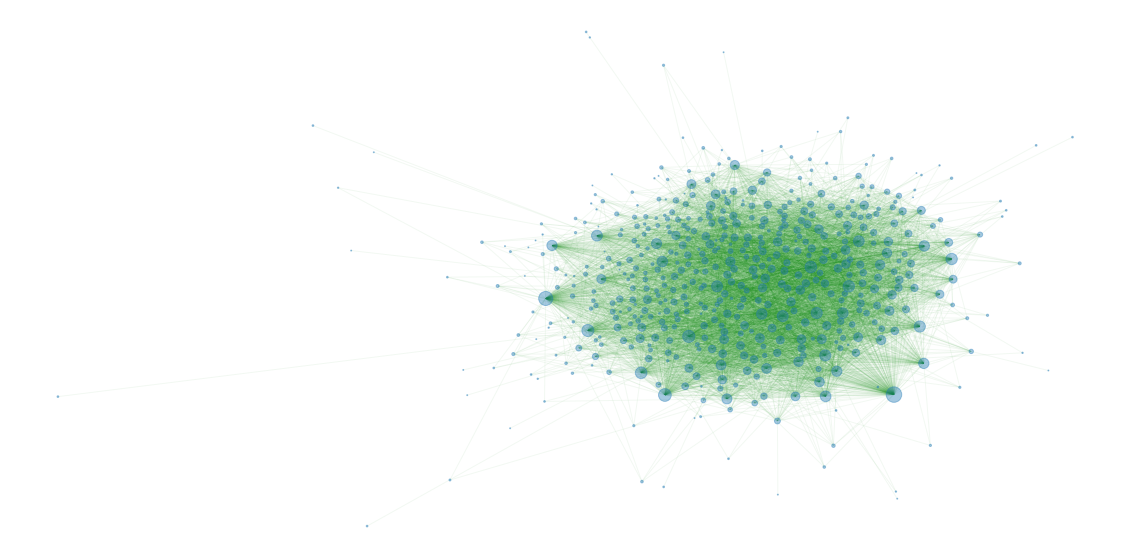

In [78]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, alpha=0.4,node_size=[v * 1 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

In [79]:
list_in=list(dict(giant_directed.in_degree()).values()) # This is all of the nodes' degrees
list_out=list(dict(giant_directed.out_degree()).values()) # This is all of the nodes' degrees

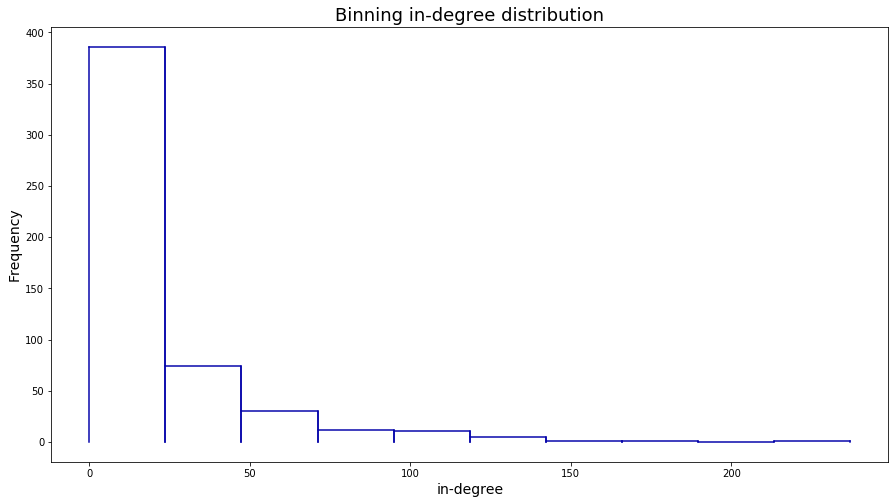

In [80]:
hist,bin_edges=np.histogram(list_in,bins=10)

rightboundary=bin_edges[1:]
leftboundary=bin_edges[:-1]
newlist_in=[] # list with leftboundary1,rightboundary1,leftboundary2,rightboundary2
newvalues_in=[] # histvalue1,histvalue1,histvalue2,histvalue2,....
for i in range(len(rightboundary)):
    newlist_in.append(leftboundary[i])
    newvalues_in.append(hist[i])
    newlist_in.append(rightboundary[i])
    newvalues_in.append(hist[i]) 
points_in=zip(newlist_in,newvalues_in)
 
plt.figure(figsize=(15,8))
plt.plot(newlist_in,newvalues_in,color='#0504aa')
for pt in points_in:
    plt.plot( [pt[0],pt[0]], [0,pt[1]],color="#0504aa" )
 
plt.title('Binning in-degree distribution',fontsize=18)
plt.xlabel("in-degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
#plt.axis([0, 140, 0, 500])
plt.show()

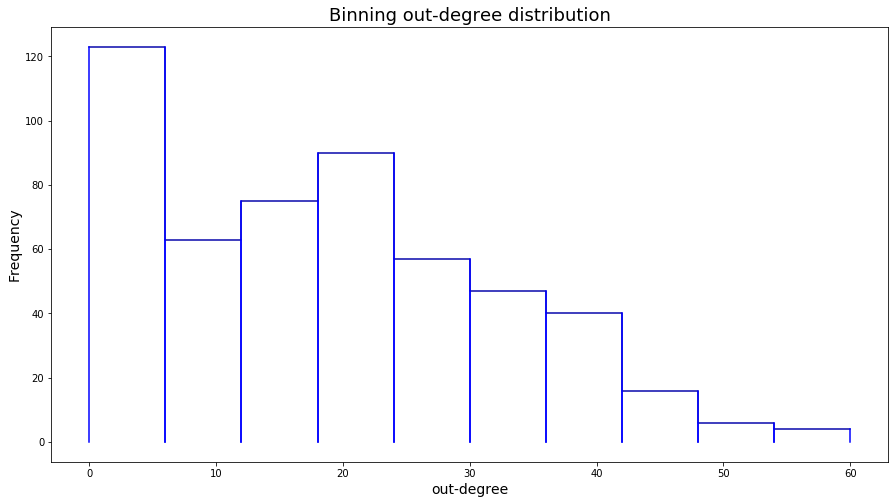

In [81]:
hist,bin_edges=np.histogram(list_out,bins=10)

rightboundary=bin_edges[1:]
leftboundary=bin_edges[:-1]
newlist_out=[] # list with leftboundary1,rightboundary1,leftboundary2,rightboundary2
newvalues_out=[] # histvalue1,histvalue1,histvalue2,histvalue2,....
for i in range(len(rightboundary)):
    newlist_out.append(leftboundary[i])
    newvalues_out.append(hist[i])
    newlist_out.append(rightboundary[i])
    newvalues_out.append(hist[i]) 
points_out=zip(newlist_out,newvalues_out)
 
plt.figure(figsize=(15,8))
plt.plot(newlist_out,newvalues_out,color='#0504aa')
for pt in points_out:
    plt.plot( [pt[0],pt[0]], [0,pt[1]],color="blue" )
 
plt.title('Binning out-degree distribution',fontsize=18)
plt.xlabel("out-degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
#plt.axis([0, 140, 0, 200])
plt.show()

### Text statistics (twitter and meetings)

#### Twitter

In [59]:
with open('tweet_dict_listversion_wrealnames.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

In [60]:
#len(tweet_dict['larsloekke']['regeringDK'])

In [61]:
pd_tweet_dict=pd.DataFrame.from_dict(tweet_dict)

In [62]:
pd_tweet_dict=pd_tweet_dict.transpose()

In [63]:
print("The number of tweet profiles who is found on twitter {}".format(pd_tweet_dict.shape[0]))

The number of tweet profiles who is found on twitter 638


In [64]:
print("The number of tweet profiles who is mentioned {}".format(pd_tweet_dict.shape[1]))

The number of tweet profiles who is mentioned 258


Each row is a politician. Which mentions others. Here is "vestager" chosen. And all the politicians she mentions with the asociated tweets:

In [65]:
pd_tweet_dict.loc[ 'vestager' , : ].dropna()

Series([], Name: vestager, dtype: object)

Finding the top 10 profiles, which tags the most (distinct):

In [66]:
pd_tweet_dict.count(axis=1).sort_values(ascending=False).head(10)

RavnTroels         14
TPalmskov          12
LiselotteLyngeJ    12
Kristianthdahl     12
GithaNelander      11
jeppelindberg      11
peter_seier        10
PernilleVermund    10
LahnLeif           10
NWammen             9
dtype: int64

Finding the top 10 profiles, which has been tagged by most (distinct):

In [67]:
pd_tweet_dict.count(axis=0).sort_values(ascending=False).head(10)

regeringDK         408
Joymogensen         58
MogensJensenS       55
Finansmin           47
oestergaard         30
FrankJensenKBH      30
MiaNyegaard         30
Statsmin            29
Pia_Kjaersgaard     27
Kristian_Jensen     27
dtype: int64

#### Meetings

# Tools, theory and analysis

## Overall idea

## Analysis step 1: Network 

## Analysis step 2: Parties and wordclouds

## Analysis step 3: Community detection and wordclouds

## Analysis step 4:  Parliament+twitter topics

## Analysis step 5: Sentiment

## Analysis step 6: Tying together

# Discussion

# Constributions

"You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain)."